# Model for classifying player position

In [1]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [2]:
# ! pip install tensorflow-addons

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns
sns.set(style='whitegrid')

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_validate, cross_val_score, KFold
from sklearn.model_selection import train_test_split

from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, OrdinalEncoder, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.inspection import permutation_importance

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks

from datetime import datetime
from collections import defaultdict
import math
import re
import random

%matplotlib inline

#pd.set_option('display.width', 500)
#pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 110)

#np.set_printoptions(precision=4, suppress=True)


Constants

In [4]:
DATA_DIR_CLEANED = 'cleaned_data/'
DATA_DIR_RAW = 'data/'

In [5]:
use_player_best_position = False

TEST_SET_CLUBS = [
    'FC Barcelona', 'FC Bayern München', 'Real Madrid', 'Paris Saint-Germain', 'Juventus', 
    'Atlético Madrid', 'Manchester City', 'Liverpool', 'Manchester United' ]

# From the problem statement, the following variables cannot be used
NOT_TO_BE_USED_COLS = ["sofifa_id", "player_url", "short_name", "long_name", "real_face", "wage_eur" ]

# Additional list of variables not needed
UNNEEDED_FEATURE_COLS = ["dob", "nationality", "value_eur", "nation_jersey_number", "loaned_from", "release_clause_eur", 
                         "team_jersey_number", "joined", "contract_valid_until", "nation_position", "international_reputation"]


SKILL_ATTACKING_COLS = [ 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys' ]
SKILL_SKILL_COLS = [ 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control' ]
SKILL_MOVEMENT_COLS = [ 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance']
SKILL_POWER_COLS = [ 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots']
SKILL_MENTALITY_COLS = [ 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure']
SKILL_DEFENDING_COLS = [ 'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle']
SKILL_GOALKEEPING_COLS = [ 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

SKILL_GK_COLS = ["gk_diving", "gk_handling", "gk_kicking", "gk_reflexes", "gk_speed", "gk_positioning"]

SKILL_COLS = SKILL_ATTACKING_COLS + SKILL_SKILL_COLS + SKILL_MOVEMENT_COLS + SKILL_POWER_COLS + SKILL_MENTALITY_COLS + SKILL_DEFENDING_COLS + SKILL_GOALKEEPING_COLS

SKILL_AGG_COLS = ["pace", "shooting", "passing", "dribbling", "defending", "physic"]

skill_agg = {
    "pace": [ 'movement_acceleration', 'movement_sprint_speed' ],
    "shooting": [ 'mentality_positioning', 'attacking_finishing', 'power_shot_power', 'power_long_shots', 'attacking_volleys', 'mentality_penalties'],
    "defending": ['mentality_interceptions', 'attacking_heading_accuracy', 'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle']
}


RESPONSE_COL = ["team_position"]

REAL_OVERALL_RATING_COLS = [ 
    'ls', 'st', 'rs',                     # strikers
    'lw', 'lf', 'cf', 'rf','rw',          # forwards
    'lam', 'cam', 'ram',                  # attacking midfielders
    'lm', 'lcm', 'cm', 'rcm', 'rm',       # midfielders
    'lwb', 'ldm','cdm','rdm','rwb',       # wingers
    'lb','lcb','cb','rcb','rb',           # backs
]



Utility Functions


In [6]:
# Split a string containing comma separated values and produces a list
def split_ignore_nan(p) -> list:   
    if p is None or p == np.nan:
        return []
    elif ( isinstance(p, float)) and math.isnan(p):
        return []
    else:
        return [ q.strip() for q in p.split(',') if len(q) >0]
    
    
# Return the number of comma separated values    
def split_count(p) -> int:   
    if p is None or p == np.nan:
        return 0
    elif ( isinstance(p, float)) and math.isnan(p):
        return 0
    else:
        items = [ q.strip() for q in p.split(',') if len(q) >0] 
        return len(items)  

In [7]:
# Executes a cell with a mathematical statement. If NaN is found
# zero is returned. This functino is applied on the rating columns where
# the value can be of the form OVR + IR or NaN
def eval_rating(r) -> int:
    if r is None or r == np.nan:
        return 0
    elif ( isinstance(r, float)) and math.isnan(r):
        return 0
    else:
        return eval(r)

In [8]:
# One hot encode a column with a string containing a comma separated list 
# attributes. The new columns are prefixed with '{prefix}_'
def csl_one_hot_encode(df_orig: pd.DataFrame, col_name: str , prefix: str) -> pd.DataFrame:
    """One hot encode a column with a string containing a comma separated list 
        attributes. The new columns are prefixed with '{prefix}_'

    Keyword arguments:
    df_orig -- DataFrame containing the source columne
    col_name -- Name of the column containing the data to convert
    prefix -- the prefix to add to the new column name
    """
        
    def clean_name(s: str) -> str:
        return re.sub(r"[# ]", "_", s).lower()

    df = df_orig.copy()
    
    # Column cleanup. The column consists of a comma separate string and some NaNs. 
    # Here we will replace the NaN with empty string and treat as no traits. 
    # Next the strings are converted to lists so a one-hot encoder can be run 

    df[col_name].fillna("", inplace=True)
    df[col_name] = df[col_name].apply(split_ignore_nan)

    mlb = MultiLabelBinarizer(sparse_output=True)

    df = pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop(col_name)),
                index=df.index,
                columns=[ f"{prefix}_{clean_name(c)}" for c in mlb.classes_])    

    return df


In [9]:
def compare_prediction( y_actual, y_hat, threshold=0.5, verbose=True, decode=False):
    prob_pos = list(zip(y_hat.flatten().tolist(), player_position_names))
    prob_pos.sort(reverse=True)
    
    predicted_positions = []
    for prob, pos in prob_pos:
        if prob >= threshold:
            predicted_positions.append((pos, f"{prob*100:.2f}%"))
    
    if verbose:
        if decode: print("Actual:    ", player_position_names[y_actual == 1])

        print("Predicted: ", predicted_positions)
        print("")

    return predicted_positions

    
# Takes player meta data and a transformed X and actual player positions (y)
# Prints out the actual and predicted positions.
def predict_player_position( player, model, i, X, y, threshold=0.5, verbose=True):
    if verbose:
        print(f"Player({i}), {player['sofifa_id']}, {player['long_name']}")
        print(f"Player positions: {player['player_positions']}, Best: {player_position_names[player['player_best_position']]}")
    y_hat = model.predict(X[i,:].reshape(1,-1))
    return compare_prediction( y[i,:], y_hat, threshold, verbose=verbose)
    
    
def calc_hamming_score(y_actual, y_hat, threshold=0.5, verbose=True):
    hl = tfa.metrics.HammingLoss(mode='multilabel', threshold=threshold)
    hl.update_state(y_actual, y_hat)
    h_loss = hl.result().numpy()
    if verbose: print('\tHamming loss:     ', h_loss)

    result = tfa.metrics.hamming_distance(y_actual, y_hat)
    h_distance = result.numpy()
    if verbose: print('\tHamming distance: ', h_distance)
    return h_loss, h_distance


#### Load the data

In [10]:
df_raw = pd.read_csv(DATA_DIR_RAW+'players_19.csv')

#### Clean / Transform data

In [11]:
df_raw = df_raw.dropna(subset=['team_position', 'player_positions'])


Cleanup skills. Make into quantative values and remove any value outside the 0-100 range.

In [12]:
# Evaluate skill columns and update them from string to an int
for col in SKILL_COLS:
    df_raw[col]= df_raw[col].apply( eval_rating)


In [13]:
df_raw[SKILL_COLS].dtypes

attacking_crossing            int64
attacking_finishing           int64
attacking_heading_accuracy    int64
attacking_short_passing       int64
attacking_volleys             int64
skill_dribbling               int64
skill_curve                   int64
skill_fk_accuracy             int64
skill_long_passing            int64
skill_ball_control            int64
movement_acceleration         int64
movement_sprint_speed         int64
movement_agility              int64
movement_reactions            int64
movement_balance              int64
power_shot_power              int64
power_jumping                 int64
power_stamina                 int64
power_strength                int64
power_long_shots              int64
mentality_aggression          int64
mentality_interceptions       int64
mentality_positioning         int64
mentality_vision              int64
mentality_penalties           int64
mentality_composure           int64
defending_marking             int64
defending_standing_tackle   

In [14]:
view_cols = ['sofifa_id', 'long_name'] + SKILL_COLS
df_raw[(df_raw[SKILL_COLS] > 100).any(axis=1) | (df_raw[SKILL_COLS] < 0).any(axis=1) ][view_cols]

,sofifa_id,long_name,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
3784,202223,Justin Meram,66,68,59,71,66,78,78,66,56,69,79,65,87,73,65,77,63,76,64,70,69,61,70,69,65,73,108,66,59,13,8,8,13,6
4671,242444,João Félix Sequeira,64,59,66,72,64,77,72,51,61,76,77,82,87,67,75,68,105,73,88,77,51,38,52,76,53,68,28,42,35,13,12,14,13,14
5856,232655,Simen Kristiansen Juklerød,71,57,44,62,48,76,70,41,69,66,93,85,77,74,61,67,87,101,72,70,57,65,62,60,50,65,64,70,69,6,9,13,5,11
6927,238666,Alexander Nandzik,63,25,39,64,24,61,67,38,41,66,87,84,85,65,87,101,73,83,56,89,53,64,57,56,34,61,65,64,64,9,11,6,14,10
8247,176645,Zdeněk Zlámal,14,13,10,56,19,12,18,12,66,40,72,60,109,51,77,36,66,33,72,18,64,33,11,71,26,65,29,23,45,66,67,67,70,70
8610,240215,Christian Capone,60,60,38,63,49,74,64,48,48,72,68,71,75,61,69,61,47,79,45,56,33,18,58,67,61,62,-11,14,17,14,8,13,9,11
10851,241002,Emmanuel Sabbi,40,63,57,56,55,70,52,43,36,70,89,90,92,63,88,57,119,71,54,55,44,17,71,51,54,63,35,14,13,14,13,8,10,7
11859,239597,Denzel Jubitana,62,65,36,64,70,72,89,77,74,70,68,68,69,57,74,65,83,59,65,105,46,36,63,58,44,56,37,36,44,6,6,15,9,11
13192,219414,Israel Alba Marín,79,78,49,70,40,56,39,108,67,59,71,74,76,50,68,88,50,79,92,89,55,55,28,50,88,42,59,59,60,14,13,12,10,12
13335,153137,Łukasz Sapela,12,14,14,38,13,15,11,15,31,23,6,-13,9,43,2,23,45,-1,7,15,28,16,13,43,25,51,17,12,14,65,67,58,61,61


In [15]:
# Remove those players whose skill values are negative or above 100.
out_of_scale =  df_raw[(df_raw[SKILL_COLS] > 100).any(axis=1) | (df_raw[SKILL_COLS] < 0).any(axis=1) ].index       
df_raw.drop(out_of_scale, inplace = True) 


Transform player_best_position using LabelEncoder

In [16]:
position_encoder = LabelEncoder()

first_entry = lambda x: pd.Series([x.split(',')[0]])

best_position = df_raw['player_positions'].apply(first_entry)
best_position.rename(columns={0:'player_best_position'},inplace=True)
df_raw['player_best_position'] = best_position

# Encode
df_raw['player_best_position'] = position_encoder.fit_transform(df_raw['player_best_position'])


print("Encoding of Positions")
ord_to_pos_dict = {}
for i, cls in enumerate(position_encoder.classes_):
    print(f"{i:3}: {cls}")
    ord_to_pos_dict[i] = cls

    
def ord_to_pos(ord: int) -> str:
    return ord_to_pos_dict[ord]

Encoding of Positions
  0: CAM
  1: CB
  2: CDM
  3: CF
  4: CM
  5: GK
  6: LB
  7: LM
  8: LW
  9: LWB
 10: RB
 11: RM
 12: RW
 13: RWB
 14: ST


Transform preferred_foot  using LabelEncoder

In [17]:
preferred_foot_encoder = LabelEncoder()

df_raw['preferred_foot'] = preferred_foot_encoder.fit_transform(df_raw['preferred_foot'])

print("Encoding of preferred_foot: ", preferred_foot_encoder.classes_)


Encoding of preferred_foot:  ['Left' 'Right']


Transform body_type using LabelEncoder

In [18]:
# Convert those few specialized body types to the commone three.
df_raw.loc[ ~df_raw['body_type'].isin(['Normal', 'Lean', 'Stocky']), 'body_type']  = 'Normal'

body_type_encoder = LabelEncoder()

df_raw['body_type'] = body_type_encoder.fit_transform(df_raw['body_type'])

print("Encoding of body_type:", body_type_encoder.classes_)

Encoding of body_type: ['Lean' 'Normal' 'Stocky']


Transform work_rate using OrdinalEncoder

In [19]:
# Order the work rating from low to high and then encode as an ordinal

work_rate_cat = [
    "Low/Low",
    "Low/Medium",
    "Low/High",
    "Medium/Low",
    "Medium/Medium",
    "Normal",
    "Medium/High",     
    "High/Low",
    "High/Medium",      
    "High/High"        
]

work_rate_encoder = OrdinalEncoder(categories={ 0: work_rate_cat})


df_raw['work_rate'] = work_rate_encoder.fit_transform(df_raw[['work_rate']] )


Transform player_tags and player_traits with one-hot encoding using MultiLabelBinarizer

In [20]:
df_raw = df_raw.join(csl_one_hot_encode(df_raw, 'player_traits', 'trait'))
df_raw = df_raw.join(csl_one_hot_encode(df_raw, 'player_tags', 'tags'))


Create separate columns for each player position

In [21]:
df_raw = df_raw.join( csl_one_hot_encode(df_raw, 'player_positions', 'plpos'))
player_position_columns = list(filter( lambda x: x.startswith('plpos') ,df_raw.columns))

player_position_names = np.asarray(player_position_columns).ravel()
player_position_names = np.char.replace(player_position_names, "plpos_", "")
player_position_names = np.char.upper(player_position_names)

print("Player Positions Shape: ", player_position_names.shape)
print("Player Positions: ", player_position_names)

df_raw[ ['player_positions'] + player_position_columns ].head(5)

Player Positions Shape:  (15,)
Player Positions:  ['CAM' 'CB' 'CDM' 'CF' 'CM' 'GK' 'LB' 'LM' 'LW' 'LWB' 'RB' 'RM' 'RW' 'RWB'
 'ST']


,player_positions,plpos_cam,plpos_cb,plpos_cdm,plpos_cf,plpos_cm,plpos_gk,plpos_lb,plpos_lm,plpos_lw,plpos_lwb,plpos_rb,plpos_rm,plpos_rw,plpos_rwb,plpos_st
0,"ST, LW",0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,"CF, RW, ST",0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,"LW, CAM",1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,GK,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,"CAM, CM",1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Drop unneeded features

In [22]:
samples = df_raw.shape[0]

columns_to_drop = \
    NOT_TO_BE_USED_COLS + \
    UNNEEDED_FEATURE_COLS + \
    SKILL_AGG_COLS + \
    SKILL_GK_COLS + \
    REAL_OVERALL_RATING_COLS + \
    ['player_tags', 'player_traits', 'player_positions', 'team_position']

if ~use_player_best_position:
    columns_to_drop += ['player_best_position']
    
print("Dropping columns: ", columns_to_drop)
df_data =df_raw.drop( columns_to_drop, axis=1)

df_data.head()

Dropping columns:  ['sofifa_id', 'player_url', 'short_name', 'long_name', 'real_face', 'wage_eur', 'dob', 'nationality', 'value_eur', 'nation_jersey_number', 'loaned_from', 'release_clause_eur', 'team_jersey_number', 'joined', 'contract_valid_until', 'nation_position', 'international_reputation', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'player_tags', 'player_traits', 'player_positions', 'team_position', 'player_best_position']


,age,height_cm,weight_kg,club,overall,potential,preferred_foot,weak_foot,skill_moves,work_rate,body_type,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,trait_1-on-1_rush,trait_avoids_using_weaker_foot,trait_backs_into_player,trait_beat_offside_trap,trait_cautious_with_crosses,trait_chip_shot_(cpu_ai_only),trait_comes_for_crosses,trait_diver,trait_dives_into_tackles_(cpu_ai_only),trait_early_crosser,...,trait_giant_throw-in,trait_injury_free,trait_injury_prone,trait_leadership,trait_long_passer_(cpu_ai_only),trait_long_shot_taker_(cpu_ai_only),trait_long_throw-in,trait_one_club_player,trait_outside_foot_shot,trait_playmaker_(cpu_ai_only),trait_power_free-kick,trait_power_header,trait_puncher,trait_rushes_out_of_goal,trait_saves_with_feet,trait_selfish,trait_set_play_specialist,trait_speed_dribbler_(cpu_ai_only),trait_takes_finesse_free_kicks,trait_target_forward,trait_team_player,trait_technical_dribbler_(cpu_ai_only),trait_through_ball,tags__acrobat,tags__aerial_threat,tags__clinical_finisher,tags__complete_defender,tags__complete_forward,tags__complete_midfielder,tags__crosser,tags__distance_shooter,tags__dribbler,tags__engine,tags__fk_specialist,tags__playmaker,tags__poacher,tags__speedster,tags__strength,tags__tackling,tags__tactician,plpos_cam,plpos_cb,plpos_cdm,plpos_cf,plpos_cm,plpos_gk,plpos_lb,plpos_lm,plpos_lw,plpos_lwb,plpos_rb,plpos_rm,plpos_rw,plpos_rwb,plpos_st
0,33,187,83,Juventus,94,94,1,4,5,7.0,1,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,31,170,72,FC Barcelona,94,94,0,4,4,4.0,1,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,26,175,68,Paris Saint-Germain,92,93,1,5,5,8.0,1,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,27,193,76,Manchester United,91,93,1,3,1,4.0,0,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,27,181,70,Manchester City,91,92,1,5,4,9.0,1,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


#### Split into Train and Test

Create train and test set by partitioning on the set of *TEST_SET_CLUBS*. We will also drop the club feature

In [23]:

train_dataset = df_data[ ~df_data['club'].isin(TEST_SET_CLUBS)].drop(['club'], axis=1)
test_dataset = df_data[ df_data['club'].isin(TEST_SET_CLUBS)].drop(['club'], axis=1) 

train_samples = train_dataset.shape[0]
test_samples = test_dataset.shape[0]

print(f"Total samples: {samples}")

print(f"Training samples: {train_samples}, {train_samples/samples*100:.2f}%")
print(f"Test samples: {test_samples}, {test_samples/samples*100:.2f}%")

Total samples: 17535
Training samples: 17259, 98.43%
Test samples: 276, 1.57%


In [24]:
if use_player_best_position:
    X_train = train_dataset.iloc[:, train_dataset.columns != 'player_best_position'].values
    y_train = train_dataset['player_best_position'].values
    X_test = test_dataset.iloc[:, test_dataset.columns != 'player_best_position'].values
    y_test = test_dataset['player_best_position'].values

else: 
    train_cols = list(set(train_dataset.columns) - set(player_position_columns))
    X_train = train_dataset[train_cols].values
    y_train = train_dataset[player_position_columns].values
    X_test = test_dataset[train_cols].values
    y_test = test_dataset[player_position_columns].values
    
    
print(f"X Training dataset: ", X_train.shape)
print(f"y Training dataset: ", y_train.shape)

print(f"X Test dataset: ", X_test.shape)
print(f"y Test dataset: ", y_test.shape)

X Training dataset:  (17259, 98)
y Training dataset:  (17259, 15)
X Test dataset:  (276, 98)
y Test dataset:  (276, 15)


In [25]:
# Fit scaler to train data
scaler = MinMaxScaler().fit(X_train)

X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)


#### Model Building

In [26]:
### Record metrics

# Accuracy
accuracy_train = {}
accuracy_test = {}

# For saving the hamming score to compare the different models.
hamming_train_loss = {}
hamming_train_dist = {}

hamming_test_loss = {}
hamming_test_dist = {}


Logistic Regression Model


In [27]:
def print_model_coefficients(model, coef_names):
    print("Model Coefficients (sorted by abs(value)):")
    coef_names = ["intercept"] + list(coef_names)
    
    model_coefficients = np.hstack([model.intercept_.reshape(-1, 1), model.coef_]).T

    coefs_formatted = []
    for name, values in zip(coef_names, model_coefficients):
        coefs_formatted.append( [name, values[0]])
        
    coefs_formatted = sorted(coefs_formatted, key=lambda x: abs(x[1]), reverse=True)
    for name, value in coefs_formatted:
        print(f"{name:32} {value:0.4}")    
        
    print("")
        

def print_summary(model, predictors, X_train, y_train, show_coef=True):

    if show_coef:
        print_model_coefficients(model, predictors)

    # Print the accuracies below
    train_accuracy = model.score(X_train, y_train)

    print(f"Train Accuracy: {train_accuracy:.4f}")

Simple Decision Tree to identify a starting max_depth

In [28]:
train_scores = []
cvmeans = []
cv_acc = []

depths = list(range(5, 30))

for d in tqdm(depths):
    model = DecisionTreeClassifier(random_state=42, max_depth=d)
    model.fit(X_train, y_train)
    train_scores.append( model.score(X_train, y_train))

    score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1)
    cv_acc.append(score)
    cvmeans.append(score.mean())

100%|██████████| 25/25 [00:37<00:00,  1.48s/it]


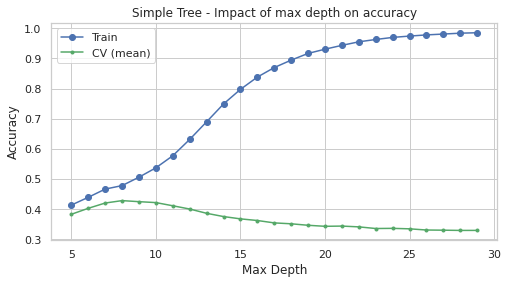

In [29]:
# Plot the accuracy
plt.figure(figsize=(8,4))
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.title('Simple Tree - Impact of max depth on accuracy')
plt.plot(depths, train_scores, 'b-', marker='o', label="Train")
plt.plot(depths, cvmeans, 'g-', marker='.', label="CV (mean)")

plt.legend()

plt.show()

Find best model based on CV score

In [30]:
dt_max_cv_acc = max(cvmeans)
dt_max_cv_index = cvmeans.index(dt_max_cv_acc)
dt_best_depth = depths[dt_max_cv_index]

print(f"Best CV score is {dt_max_cv_acc:0.4f} with max_depth of {dt_best_depth}")

Best CV score is 0.4286 with max_depth of 8


In [31]:
dt_model = DecisionTreeClassifier(max_depth=dt_best_depth).fit(X_train, y_train)

dt_y_pred_train = dt_model.predict(X_train)
dt_y_pred_test = dt_model.predict(X_test)

dt_train_score = accuracy_score(y_train, dt_y_pred_train)
dt_test_score = accuracy_score(y_test, dt_y_pred_test)

print(f"Simple DecisionTree Accuracy: depth={dt_best_depth}, TrainAcc={dt_train_score:0.4f}, TestAcc={dt_test_score:0.4f}")


Simple DecisionTree Accuracy: depth=8, TrainAcc=0.4784, TestAcc=0.4094


RandomForest - Find a max depth starting from the DecisionTreeClassifier's best max_depth

In [32]:
acc_train_scores = []
acc_val_scores =[]

depths = list(range(dt_best_depth, 30))

for d in tqdm(depths):
    rf_model = RandomForestClassifier(random_state=42, max_depth=d, max_features="sqrt", n_jobs=-1)
    rf_model.fit(X_train, y_train)
    acc_train_scores.append( rf_model.score(X_train, y_train))
    
    cv_scores = cross_validate(rf_model, X_train, y_train, cv=5, return_estimator=True, n_jobs=-1)
    cv_score = cv_scores['test_score'].mean()
    acc_val_scores.append(cv_score)
    

100%|██████████| 22/22 [03:30<00:00,  9.56s/it]


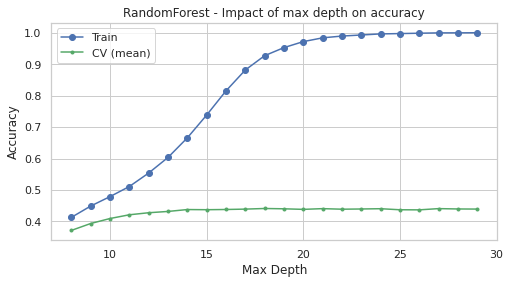

In [33]:
# Plot the accuracy
plt.figure(figsize=(8,4))
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
#plt.ylim(bottom=0.5)
plt.title('RandomForest - Impact of max depth on accuracy')
plt.plot(depths, acc_train_scores, 'b-', marker='o', label="Train")
plt.plot(depths, acc_val_scores, 'g-', marker='.', label="CV (mean)")

plt.legend()

plt.show()

In [34]:
rf_max_cv_acc = max(acc_val_scores)
rf_max_cv_index = acc_val_scores.index(rf_max_cv_acc)
rf_best_depth = depths[rf_max_cv_index]

print(f"Best RandomForest CV score is {rf_max_cv_acc:0.4f} with max_depth of {rf_best_depth}")    


Best RandomForest CV score is 0.4412 with max_depth of 18


RandomForest - find best number of estimators

In [35]:
print("Using max_depth = ", rf_best_depth)

min_estimators = 50
max_estimators = 250
step = 5

n_estimators = list(range(min_estimators, max_estimators + 1, step))

print(f"Using max_depth={rf_best_depth}, estimator range=[{min_estimators}, {max_estimators}]")

acc_train_scores = []
acc_val_scores =[]

for i in tqdm(n_estimators):
    rf_model = RandomForestClassifier(n_estimators=i, random_state=42, max_depth=rf_best_depth, max_features="sqrt", n_jobs=-1)
    rf_model.fit(X_train, y_train)
    acc_train_scores.append( rf_model.score(X_train, y_train))
    
    cv_scores = cross_validate(rf_model, X_train, y_train, cv=5, return_estimator=True)
    cv_score = cv_scores['test_score'].mean()
    acc_val_scores.append(cv_score)
    

  0%|          | 0/41 [00:00<?, ?it/s]

Using max_depth =  18
Using max_depth=18, estimator range=[50, 250]


100%|██████████| 41/41 [13:18<00:00, 19.47s/it]


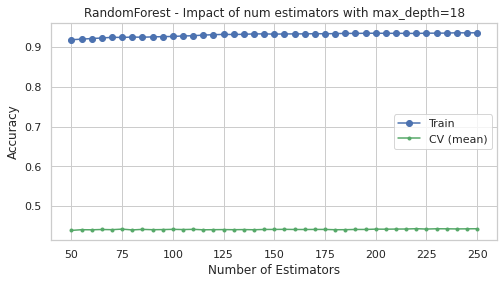

In [36]:
# Plot the accuracy
plt.figure(figsize=(8,4))
plt.ylabel("Accuracy")
plt.xlabel("Number of Estimators")
#plt.ylim(bottom=0.3)
plt.title(f"RandomForest - Impact of num estimators with max_depth={rf_best_depth}")
plt.plot(n_estimators, acc_train_scores, 'b-', marker='o', label="Train")
plt.plot(n_estimators, acc_val_scores, 'g-', marker='.', label="CV (mean)")

plt.legend()

plt.show()

In [37]:
rf_max_cv_acc = max(acc_val_scores)
rf_max_cv_index = acc_val_scores.index(rf_max_cv_acc)
rf_best_num_estimators = n_estimators[rf_max_cv_index]

print(f"Best RandomForest CV score is {rf_max_cv_acc:.4f} at index={rf_max_cv_index} with n_estimators={rf_best_num_estimators}, best_max_depth={rf_best_depth}")


Best RandomForest CV score is 0.4428 at index=34 with n_estimators=220, best_max_depth=18


Create RandomForest model using best depth and estimator values

In [38]:
print(f"Using n_estimators={rf_best_num_estimators}, best_max_depth={rf_best_depth}")

best_rf_model = RandomForestClassifier(n_estimators=rf_best_num_estimators, max_depth=rf_best_depth, max_features="sqrt")
best_rf_model.fit(X_train, y_train)

rf_y_pred_train = best_rf_model.predict(X_train)
rf_y_pred_test = best_rf_model.predict(X_test)

rf_train_score = accuracy_score(y_train, rf_y_pred_train)
rf_test_score = accuracy_score(y_test, rf_y_pred_test)

accuracy_train['RF'] = rf_train_score
accuracy_test['RF'] = rf_test_score

print(f"RandomForest Accuracy: Train Set: {rf_train_score:0.4f}")
print(f"RandomForest Accuracy: Test Set: {rf_test_score:0.4f}")

# Get and save the hamming scores
print("RandomForest Train: ")
h_l, h_d = calc_hamming_score( y_train, rf_y_pred_train)
hamming_train_loss['RF'] = h_l
hamming_train_dist['RF'] = h_d

print("RandomForest Test: ")
h_l, h_d = calc_hamming_score( y_test, rf_y_pred_test)
hamming_test_loss['RF'] = h_l
hamming_test_dist['RF'] = h_d


Using n_estimators=220, best_max_depth=18
RandomForest Accuracy: Train Set: 0.9344
RandomForest Accuracy: Test Set: 0.4601
RandomForest Train: 
	Hamming loss:      0.0047859093
	Hamming distance:  0.07178863
RandomForest Test: 
	Hamming loss:      0.06594204
	Hamming distance:  0.98913044


We will use the predict_proba to get the per class label probabilities to be able to order the results. We also want to capture the resulting hamming score on the predict_proba results. However, the predict_proba returns shape is different from what is returned by keras. It returns a list of n_outputs such that it is a list of length 15. Each entry in the list if equal to the number of samples. For each is a probability results that sums to 1.0

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba

fit ( n_samples x n_features, n_samples x n_outputs)

predict( n_samples x n_features) -> n_samples x n_outputs

predict_proba( n_samples x n_features) -> n_outputs x n_samples x 2

Below we will use the utility function to restructure the returned results.


In [39]:
# Utility function to reshape the output of a predict_proba to be able
# to get the hamming loss and distance using the same function as the NN. 
def rf_reshape_proba(y_proba):
    # Convert to an numpy array to make it easier to manipulate
    tmp = np.asarray(y_proba)
    
    # We will only use the true column and then transpose so each 
    # row repressents a sample
    tmp = tmp[:,:,1].T

    return tmp

# Test that rf_reshape_proba returns the correct results/shape.
# We compare thr predict_proba output filtered by threshold to 
# the output of a predict. 
num_samples = 3
samples = X_train[0:num_samples].reshape(-1, 98)

rf_y_pred_train = best_rf_model.predict(samples)

rf_y_proba_train = best_rf_model.predict_proba(samples)
r2 = (rf_reshape_proba(rf_y_proba_train) >= 0.5).astype(int)

assert (r2.shape[0] == num_samples) and (r2.shape[1] == y_test.shape[1])
assert rf_y_pred_train.shape == r2.shape
assert np.array_equal( rf_y_pred_train, r2)

In [40]:
# Test that rf_reshape_proba returns the correct results/shape
# We compare its ouput with threshold to the output of a predict
# Take the first three training samples
num_samples = X_train.shape[0]
samples = X_train[0:num_samples].reshape(-1, 98)

rf_y_pred_train = best_rf_model.predict(samples)

rf_y_proba_train = best_rf_model.predict_proba(samples)
r2 = (rf_reshape_proba(rf_y_proba_train) >= 0.5).astype(int)

assert (r2.shape[0] == num_samples) and (r2.shape[1] == y_train.shape[1])
assert rf_y_pred_train.shape == r2.shape
assert np.array_equal( rf_y_pred_train, r2)

In [41]:
# Test that rf_reshape_proba returns the correct results/shape
# We compare its ouput with threshold to the output of a predict
# Take the first three training samples
num_samples = X_test.shape[0]
samples = X_train[0:num_samples].reshape(-1, 98)

rf_y_pred_test = best_rf_model.predict(samples)

rf_y_proba_test = best_rf_model.predict_proba(samples)
r2 = (rf_reshape_proba(rf_y_proba_test) >= 0.5).astype(int)

assert (r2.shape[0] == num_samples) and (r2.shape[1] == y_test.shape[1])
assert rf_y_pred_test.shape == r2.shape
assert np.array_equal( rf_y_pred_test, r2)

In [42]:
# Get then save the hamming info
rf_y_pred_train = best_rf_model.predict_proba(X_train)
rf_y_pred_train = rf_reshape_proba(rf_y_pred_train)

rf_train_score = accuracy_score(y_train, (rf_y_pred_train >= 0.5).astype(int))
# accuracy_train['RF Proba'] = rf_train_score
print(f"RandomForest Accuracy: Train Set: {rf_train_score:0.4f}")

h_l, h_d = calc_hamming_score( y_train, rf_y_pred_train)
#hamming_train_loss['RF Proba'] = h_l
#hamming_train_dist['RF Proba'] = h_d

rf_y_pred_test = best_rf_model.predict_proba(X_test)
rf_y_pred_test = rf_reshape_proba(rf_y_pred_test)

rf_test_score = accuracy_score(y_test, (rf_y_pred_test >= 0.5).astype(int))
# accuracy_test['RF Proba'] = rf_test_score
print(f"RandomForest Accuracy: Test Set: {rf_test_score:0.4f}")

h_l, h_d = calc_hamming_score( y_test, rf_y_pred_test)
#hamming_test_loss['RF Proba'] = h_l
#hamming_test_dist['RF Proba'] = h_d

RandomForest Accuracy: Train Set: 0.9344
	Hamming loss:      0.0047859093
	Hamming distance:  1.5422099
RandomForest Accuracy: Test Set: 0.4601
	Hamming loss:      0.06594204
	Hamming distance:  1.6485507


#### Feature Importance

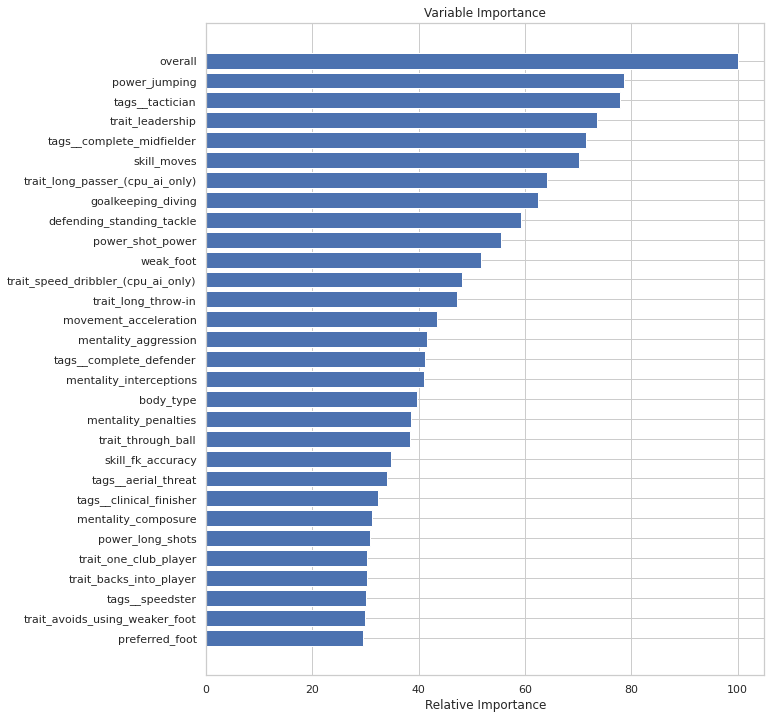

In [43]:
n_top = 30

#Top Features
feature_importance = best_rf_model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
top_idx = sorted_idx[-n_top:]

pos = np.arange(top_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[top_idx], align='center')
plt.yticks(pos, train_dataset.columns[top_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

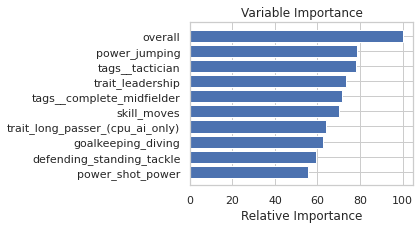

In [44]:
n_top = 10

#Top Features
feature_importance = best_rf_model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
top_idx = sorted_idx[-n_top:]

pos = np.arange(top_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(4,3))
plt.barh(pos, feature_importance[top_idx], align='center')
plt.yticks(pos, train_dataset.columns[top_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [45]:
for i, c in enumerate(train_dataset.columns):
    print(i, c)

0 age
1 height_cm
2 weight_kg
3 overall
4 potential
5 preferred_foot
6 weak_foot
7 skill_moves
8 work_rate
9 body_type
10 attacking_crossing
11 attacking_finishing
12 attacking_heading_accuracy
13 attacking_short_passing
14 attacking_volleys
15 skill_dribbling
16 skill_curve
17 skill_fk_accuracy
18 skill_long_passing
19 skill_ball_control
20 movement_acceleration
21 movement_sprint_speed
22 movement_agility
23 movement_reactions
24 movement_balance
25 power_shot_power
26 power_jumping
27 power_stamina
28 power_strength
29 power_long_shots
30 mentality_aggression
31 mentality_interceptions
32 mentality_positioning
33 mentality_vision
34 mentality_penalties
35 mentality_composure
36 defending_marking
37 defending_standing_tackle
38 defending_sliding_tackle
39 goalkeeping_diving
40 goalkeeping_handling
41 goalkeeping_kicking
42 goalkeeping_positioning
43 goalkeeping_reflexes
44 trait_1-on-1_rush
45 trait_avoids_using_weaker_foot
46 trait_backs_into_player
47 trait_beat_offside_trap
48 tra

### Neural Net Model

In [46]:
# build a NN model

tf.random.set_seed(42)

kernel_weight = 0.00001

#reset the model 
NN_model = tf.keras.models.Sequential()

# input layers 
NN_model.add(tf.keras.layers.Dense(units=100,
                                   input_shape=(X_train.shape[1],),
                                   activation = 'tanh', 
                                   kernel_initializer='he_uniform', 
                                   bias_initializer='random_normal', 
                                   kernel_regularizer=regularizers.l2(kernel_weight)
                                   ))
NN_model.add(tf.keras.layers.Dropout(0.2))
NN_model.add(tf.keras.layers.Dense(units=100, activation = 'tanh', kernel_regularizer=regularizers.l2(kernel_weight), name='hidden_01'))
NN_model.add(tf.keras.layers.Dropout(0.1))
NN_model.add(tf.keras.layers.Dense(units=100, activation = 'tanh', kernel_regularizer=regularizers.l2(kernel_weight), name='hidden_02'))
NN_model.add(tf.keras.layers.Dropout(0.1))
NN_model.add(tf.keras.layers.Dense(units=100, activation = 'tanh', kernel_regularizer=regularizers.l2(kernel_weight), name='hidden_03'))
NN_model.add(tf.keras.layers.Dropout(0.1))
NN_model.add(tf.keras.layers.Dense(units=50, activation = 'tanh', kernel_regularizer=regularizers.l2(kernel_weight), name='hidden_04'))
NN_model.add(tf.keras.layers.Dropout(0.1))

# output layer 
NN_model.add(tf.keras.layers.Dense(15,  activation='sigmoid', name='output'))

# Summary 
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               9900      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
hidden_01 (Dense)            (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
hidden_02 (Dense)            (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
hidden_03 (Dense)            (None, 100)               1

In [47]:
# Compile and fit
learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate)

NN_model.compile(
                 optimizer=optimizer,
                 loss='binary_crossentropy',
                 #metrics=['categorical_accuracy'],
                 metrics=['accuracy']
)


In [48]:
# Directory for tensorboard logs and saved models

!mkdir -p logs
!mkdir -p models


In [49]:
%%time

batch_size = 128
epochs = 500

filename = 'plr_pos_' + datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_filepath = '/tmp/checkpoint-' + filename

logdir = "logs/" + filename
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=55)
model_checkpoint = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=0)

callback_list = [ 
    early_stopping,
    model_checkpoint,
    tensorboard_callback
]

k_folds = 5
kf = KFold(n_splits=k_folds, random_state=None, shuffle=True)

kf_history = []

i = 0
for train_index, val_index in kf.split(X_scaled_train):
    kf_X_train = X_scaled_train[train_index]
    kf_X_val = X_scaled_train[val_index]
    kf_y_train = y_train[train_index]
    kf_y_val = y_train[val_index]

    print(f"K Fold Validation step => {i}/{k_folds}")
   
    history = NN_model.fit(kf_X_train, kf_y_train, 
                             batch_size=batch_size, 
                             epochs=epochs,  
                             validation_data=(kf_X_val,kf_y_val), 
                             callbacks=callback_list,
                             verbose=0)
    kf_history.append(history)
    
    i+=1
    
# The model weights (that are considered the best) are loaded into the model.
NN_model.load_weights(checkpoint_filepath)

K Fold Validation step => 0/5
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
K Fold Validation step => 1/5
K Fold Validation step => 2/5
K Fold Validation step => 3/5
K Fold Validation step => 4/5
CPU times: user 2min 19s, sys: 11.8 s, total: 2min 31s
Wall time: 1min 25s


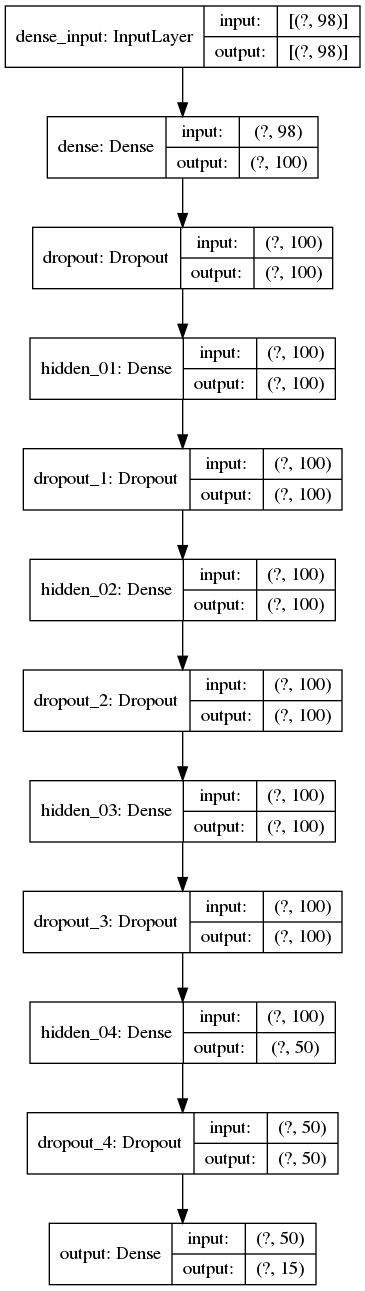

In [50]:
dot_img_file = './models/ply_pos_model.png'
tf.keras.utils.plot_model(NN_model, to_file=dot_img_file, show_shapes=True)

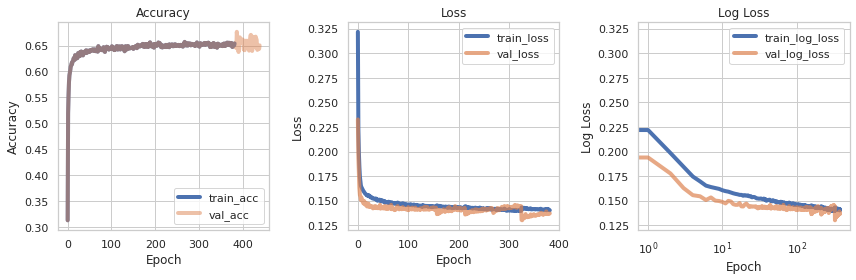

In [51]:

    
def plot_histories_accuracy(histories, key='accuracy'):
    
    history_accuracy = []
    history_val_accuracy = []
    history_loss = []
    history_val_loss = []
    for h in histories:
        history_accuracy = history_accuracy + h.history['accuracy']
        history_val_accuracy = history_accuracy + h.history['val_accuracy']
        history_loss = history_loss + h.history['loss']
        history_val_loss = history_val_loss + h.history['val_loss']

    plt.figure(figsize=[12,4])
    
    plt.subplot(1,3,1)
    plt.plot(history_accuracy, label = 'train_acc', linewidth=4)    
    plt.plot(history_val_accuracy, label = 'val_acc', linewidth=4, alpha=.5)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.legend(loc='best')
    
    plt.subplot(1,3,2)
    plt.plot(history_loss, label = 'train_loss', linewidth=4)
    plt.plot(history_val_loss, label = 'val_loss', linewidth=4, alpha=.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Loss")
    plt.legend(loc='best')
    
    plt.subplot(1,3,3)
    plt.semilogx(history_loss, label = 'train_log_loss', linewidth=4)
    plt.semilogx(history_val_loss, label = 'val_log_loss', linewidth=4, alpha=.7)
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss')
    plt.title("Log Loss")
    plt.legend(loc='best')
    
    plt.tight_layout()
    
    
#plot_accuracy(history, 'categorical_accuracy')
plot_histories_accuracy(kf_history)

Get the accuracy, hamming loss and distance across the entire train and test set.

In [52]:
accuracy_train['NN'] = NN_model.evaluate(X_scaled_train, y_train, verbose=0)[1]
print(f"NN Accuracy: Train Set: {accuracy_train['NN']:0.4f}")

y_hat_train = NN_model.predict(X_scaled_train)
h_l, h_d = calc_hamming_score(y_train, y_hat_train)
hamming_train_loss['NN'] = h_l
hamming_train_dist['NN'] = h_d

NN Accuracy: Train Set: 0.6736
	Hamming loss:      0.051273737
	Hamming distance:  1.6481836


In [53]:
accuracy_test['NN'] = NN_model.evaluate(X_scaled_test, y_test, verbose=0)[1]
print(f"NN Accuracy: Test Set: {accuracy_test['NN']:0.4f}")

y_hat_test = NN_model.predict(X_scaled_test)
h_l, h_d = calc_hamming_score(y_test, y_hat_test)
hamming_test_loss['NN'] = h_l
hamming_test_dist['NN'] = h_d

NN Accuracy: Test Set: 0.6377
	Hamming loss:      0.06256039
	Hamming distance:  1.7391304


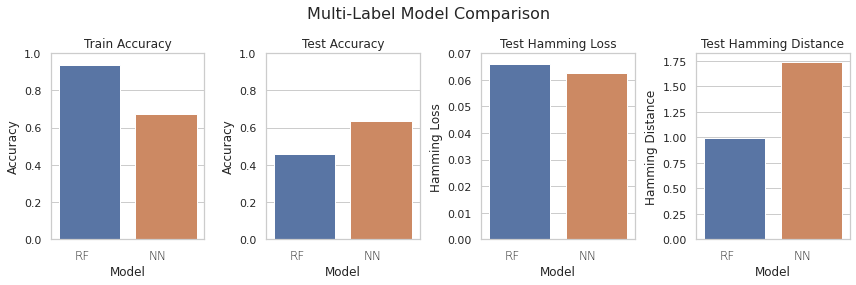

In [86]:

df_acc_train = pd.DataFrame(accuracy_train.items(), columns=['Model', 'Accuracy'])
df_acc_test = pd.DataFrame(accuracy_test.items(), columns=['Model', 'Accuracy'])

df_hamming_train_loss = pd.DataFrame(hamming_train_loss.items(), columns=['Model', 'Hamming Loss'])
df_hamming_test_loss = pd.DataFrame(hamming_test_loss.items(), columns=['Model', 'Hamming Loss'])

df_hamming_train_dist = pd.DataFrame(hamming_train_dist.items(), columns=['Model', 'Hamming Distance'])
df_hamming_test_dist = pd.DataFrame(hamming_test_dist.items(), columns=['Model', 'Hamming Distance'])

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
ax = ax.ravel()
fig.suptitle(f"Multi-Label Model Comparison", fontsize = 16)


bplot = sns.barplot(x = 'Model', y = 'Accuracy', data=df_acc_train, ax=ax[0])
bplot.set_ylim(0, 1.0)
bplot.set_title("Train Accuracy")
b = bplot.set_xticklabels(bplot.get_xticklabels(), rotation=0,
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large')

bplot = sns.barplot(x = 'Model', y = 'Accuracy', data=df_acc_test, ax=ax[1])
bplot.set_ylim(0, 1.0)
bplot.set_title("Test Accuracy")
b = bplot.set_xticklabels(bplot.get_xticklabels(), rotation=0,
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large')

bplot = sns.barplot(x = 'Model', y = 'Hamming Loss', data = df_hamming_test_loss, ax=ax[2])
bplot.set_title("Test Hamming Loss")
bplot.set_ylim(0,0.07)
b = bplot.set_xticklabels(bplot.get_xticklabels(), rotation=0,
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large')

bplot = sns.barplot(x = 'Model', y = 'Hamming Distance', data = df_hamming_test_dist, ax=ax[3])
bplot.set_title("Test Hamming Distance")
b = bplot.set_xticklabels(bplot.get_xticklabels(), rotation=0,
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large')
plt.ylim(0,)


plt.tight_layout()

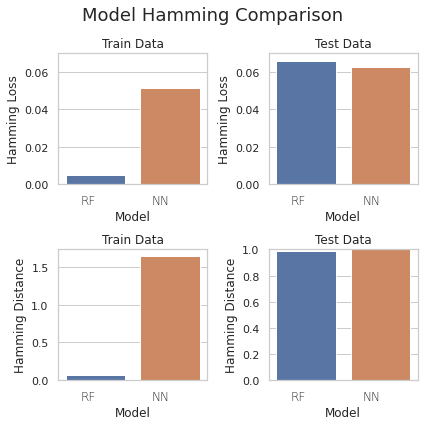

In [55]:

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
ax = ax.ravel()
fig.suptitle(f"Model Hamming Comparison", fontsize = 18)


bplot = sns.barplot(x = 'Model', y = 'Hamming Loss', data = df_hamming_train_loss, ax=ax[0])
bplot.set_title("Train Data")
bplot.set_ylim(0,0.07)
b = bplot.set_xticklabels(bplot.get_xticklabels(), rotation=0,
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large')

bplot = sns.barplot(x = 'Model', y = 'Hamming Loss', data = df_hamming_test_loss, ax=ax[1])
bplot.set_title("Test Data")
bplot.set_ylim(0,0.07)
b = bplot.set_xticklabels(bplot.get_xticklabels(), rotation=0,
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large')


bplot = sns.barplot(x = 'Model', y = 'Hamming Distance', data = df_hamming_train_dist, ax=ax[2])
bplot.set_title("Train Data")
b = bplot.set_xticklabels(bplot.get_xticklabels(), rotation=0,
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large')
plt.ylim(0,)

bplot = sns.barplot(x = 'Model', y = 'Hamming Distance', data = df_hamming_test_dist, ax=ax[3])
bplot.set_title("Test Data")
b = bplot.set_xticklabels(bplot.get_xticklabels(), rotation=0,
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large')
plt.ylim(0,)

plt.tight_layout()

Randomly select players from the test set and predict possible positions.

In [56]:
samples = random.sample(range(len(X_test)), 10)
test_players = df_raw[ df_raw['club'].isin(TEST_SET_CLUBS)]
for i in samples:
    player = test_players[['sofifa_id', 'long_name', 'player_positions', 'player_best_position']].iloc[i]
    predict_player_position(player, best_rf_model, i, X_test, y_test)


Player(198), 208088, Sergi Samper Montañá
Player positions: CDM, CM, Best: CDM
Predicted:  [('CM', '100.00%'), ('CDM', '100.00%')]

Player(120), 231866, Rodrigo Hernández Cascante
Player positions: CM, CDM, Best: CM
Predicted:  [('CM', '100.00%'), ('CDM', '100.00%')]

Player(21), 178603, Mats  Hummels
Player positions: CB, Best: CB
Predicted:  [('CDM', '100.00%')]

Player(134), 193105, Alphonse Areola
Player positions: GK, Best: GK
Predicted:  [('GK', '100.00%')]

Player(77), 218667, Bernardo Mota Veiga de Carvalho e Silva
Player positions: RW, CAM, Best: RW
Predicted:  [('CAM', '100.00%')]

Player(209), 237156, Moussa Wagué
Player positions: RB, Best: RB
Predicted:  [('RB', '100.00%')]

Player(24), 200145, Carlos Henrique Venancio Casimiro
Player positions: CDM, Best: CDM
Predicted:  [('CM', '100.00%'), ('CDM', '100.00%')]

Player(142), 199715, Víctor Machín Pérez
Player positions: LM, RM, Best: LM
Predicted:  [('ST', '100.00%')]

Player(30), 173731, Gareth Frank Bale
Player positions

In [57]:
# Use the same samples with the NN model
for i in samples:
    player = test_players[['sofifa_id', 'long_name', 'player_positions', 'player_best_position']].iloc[i]
    predict_player_position(player, NN_model, i, X_scaled_test, y_test)


Player(198), 208088, Sergi Samper Montañá
Player positions: CDM, CM, Best: CDM
Predicted:  [('CDM', '91.53%'), ('CM', '90.88%')]

Player(120), 231866, Rodrigo Hernández Cascante
Player positions: CM, CDM, Best: CM
Predicted:  [('CM', '95.60%'), ('CDM', '82.81%')]

Player(21), 178603, Mats  Hummels
Player positions: CB, Best: CB
Predicted:  [('CB', '99.37%')]

Player(134), 193105, Alphonse Areola
Player positions: GK, Best: GK
Predicted:  [('GK', '100.00%')]

Player(77), 218667, Bernardo Mota Veiga de Carvalho e Silva
Player positions: RW, CAM, Best: RW
Predicted:  [('CAM', '53.03%')]

Player(209), 237156, Moussa Wagué
Player positions: RB, Best: RB
Predicted:  [('RB', '95.50%')]

Player(24), 200145, Carlos Henrique Venancio Casimiro
Player positions: CDM, Best: CDM
Predicted:  [('CB', '94.53%')]

Player(142), 199715, Víctor Machín Pérez
Player positions: LM, RM, Best: LM
Predicted:  [('LM', '65.68%'), ('RM', '55.47%')]

Player(30), 173731, Gareth Frank Bale
Player positions: RW, ST, Be

Plot best position and compare to predicted best position

In [58]:
# Positions order from offense to defense
position_order = ['ST', 'CF', 'LW', 'CAM', 'RW', 'LM', 'CM', 'RM', 'LWB', 'CDM', 'RWB', 'LB', 'CB', 'RB', 'GK', 'None']

In [59]:
# Get 16 colors to represent each of the different position plus no position. 
pos_color_palette = { k:v for k, v in zip( position_order + ['None'], sns.color_palette("Paired") + sns.color_palette("Set2")[-4:])}

In [83]:
print("Position colors:")
for pos_color in zip( position_order, sns.color_palette("Paired").as_hex() + sns.color_palette("Set2").as_hex() ):
    print(pos_color)

Position colors:
('ST', '#a6cee3')
('CF', '#1f78b4')
('LW', '#b2df8a')
('CAM', '#33a02c')
('RW', '#fb9a99')
('LM', '#e31a1c')
('CM', '#fdbf6f')
('RM', '#ff7f00')
('LWB', '#cab2d6')
('CDM', '#6a3d9a')
('RWB', '#ffff99')
('LB', '#b15928')
('CB', '#66c2a5')
('RB', '#fc8d62')
('GK', '#8da0cb')
('None', '#e78ac3')


In [60]:
test_players = df_raw[ df_raw['club'].isin(TEST_SET_CLUBS)].copy()
best_position = df_raw['player_positions'].apply(first_entry)
best_position.rename(columns={0:'best_position'},inplace=True)
test_players['best_position'] = best_position


In [66]:
def plot_predicted_best_position( model, players_metadata, X, Y, title):
    predicted_best_position = []
    for i in range(len(players_metadata)):
        player = players_metadata[['sofifa_id', 'long_name', 'player_positions', 'player_best_position']].iloc[i]
        pos = predict_player_position(player, model, i, X, Y, verbose=False)
        if len(pos) == 0: predicted_best_position.append("None")
        else: predicted_best_position.append(pos[0][0])    

    players_metadata['predicted_best_position'] = np.array(predicted_best_position)

    fig, ax = plt.subplots(figsize=(12,6))
    g = sns.swarmplot(
        x="best_position", 
        y=players_metadata.index, 
        hue="predicted_best_position", 
        data=players_metadata, 
        order=position_order, 
        hue_order=position_order, 
        size=7, 
        palette=pos_color_palette
    )
    g.set(yticklabels=[], xlabel='Best Position')
    g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, title="Predicted");
    fig.suptitle(title);
    plt.tight_layout();
    
    return predicted_best_position


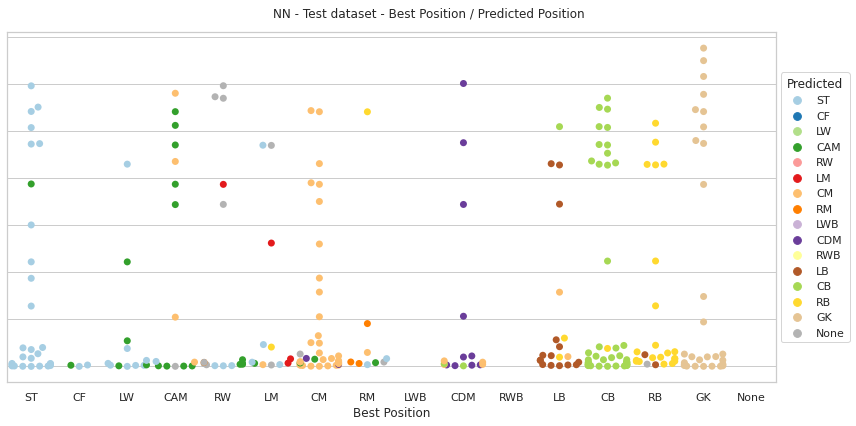

In [67]:
test_players['nn_best_position'] = plot_predicted_best_position(NN_model, test_players, X_scaled_test, y_test, "NN - Test dataset - Best Position / Predicted Position")

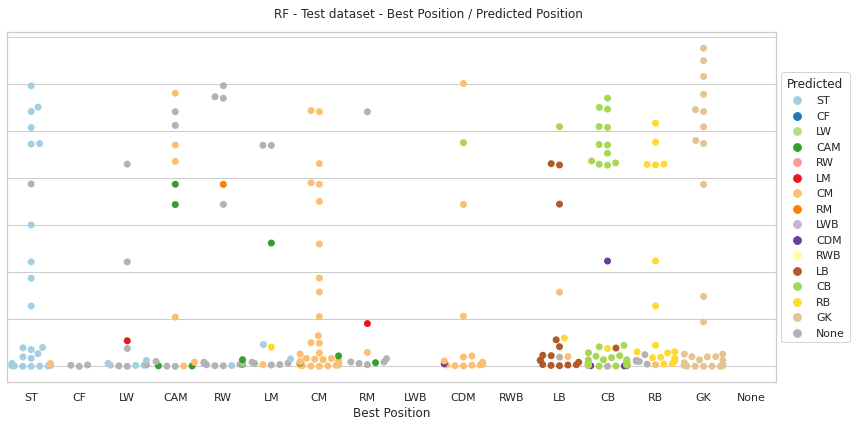

In [71]:
test_players['rf_best_position'] = plot_predicted_best_position(best_rf_model, test_players, X_test, y_test, "RF - Test dataset - Best Position / Predicted Position")

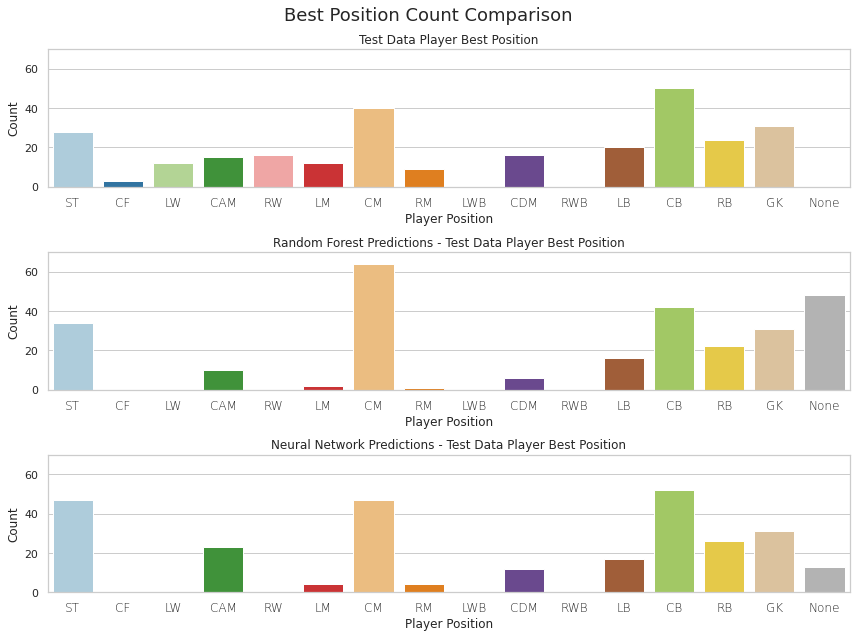

In [87]:
def plot_best_position_count(x, ax, title):
    cplot= sns.countplot(x=x, data=test_players, palette=pos_color_palette, order=position_order, ax=ax)
    cplot.set_xlabel('Player Position')
    cplot.set_ylabel('Count')
    cplot.set_ylim(0,70)
    cplot.set_title(title)

    cplot.set_xticklabels(cplot.get_xticklabels(),
                      rotation=0,
                      horizontalalignment='center',
                      fontweight='light',
                      fontsize='large');
    
    

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
ax = ax.ravel()
fig.suptitle(f"Best Position Count Comparison", fontsize = 18)

plot_best_position_count('best_position',    ax[0], "Test Data Player Best Position")
plot_best_position_count('rf_best_position', ax[1], "Random Forest Predictions - Test Data Player Best Position")
plot_best_position_count('nn_best_position', ax[2], "Neural Network Predictions - Test Data Player Best Position")
plt.tight_layout()
plt.show()